# exp004

連続量に2乗項追加


CV | 15300.449778939059

PublicLB| 

------------------
baseline

CV | 15121.815522879584

PrivateLB | 26707.419

In [1]:
MODEL_NAME = 'exp004'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from functools import partial

import lightgbm as lgb

import json

from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer, LambdaEncoder
    

In [3]:
import time

from contextlib import contextmanager


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [4]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

In [5]:
def pre_process(df, phase='train'):
    if(phase == 'train'):
        df = df[df['MS SubClass'] < 150]
        df = df[df['Lot Area'] < 15000]
        df = df[df['1st Flr SF'] < 1800]
        df = df[(df['SalePrice'] > 100000) & (df['SalePrice'] < 200000)]
    
    return df

In [6]:
df_train = pre_process(df_train, phase="train")
df_test = pre_process(df_test, phase="test")

In [7]:
# numeric_columns = [continuous_columns, discrete_columns]
# numeric_columns = ['index','Order', 'MS SubClass', 'Lot Area', 'Overall Qual',
#        'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF',
#        '2nd Flr SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
#        'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
#        'Open Porch SF', 'Mo Sold', 'Yr Sold', 'SalePrice']

target_column = 'SalePrice'
index_column = 'index'

continuous_columns = ['Lot Area','BsmtFin SF 1','Bsmt Unf SF','Total Bsmt SF','1st Flr SF',
                      '2nd Flr SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF']

discrete_columns = ['Order','MS SubClass','Overall Qual','Overall Cond','Year Built',
                    'Year Remod/Add','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd',
                    'Fireplaces','Mo Sold','Yr Sold']

categorical_columns = ['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Exter Qual', 'Foundation', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Paved Drive', 'Sale Type',
       'Sale Condition']

In [8]:
encoder = Pipeline([
    SelectCategorical(exclude_cols=[]),
    LabelEncoder(output_suffix=""),
])
df_train_categorical = encoder.fit_transform(df_train)
df_test_categorical = encoder.transform(df_test)

In [9]:
encoder = Pipeline([
    LambdaEncoder(
        lambda x: x * x,
        output_prefix="",
        output_suffix="_squared",
        drop_origin=False,
    ),
])
df_train_continuous = encoder.transform(df_train[continuous_columns])
df_test_continuous = encoder.transform(df_test[continuous_columns])

In [10]:
df_train = pd.concat([df_train[index_column],
                      df_train_continuous,
                      df_train[discrete_columns],
                      df_train_categorical,
                      df_train[target_column]], axis=1)
df_test = pd.concat([df_test[index_column],
                     df_test_continuous,
                     df_train[discrete_columns],
                     df_test_categorical], axis=1)

In [11]:
df_train.head(3)

,index,Lot Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Garage Area,Wood Deck SF,...,Exter Qual,Foundation,Heating QC,Central Air,Electrical,Kitchen Qual,Paved Drive,Sale Type,Sale Condition,SalePrice
0,200,9000,554.725259,490.862838,620.339061,941,0,2358,381.014258,0,...,0,0,0,0,0,0,0,0,0,158000
1,3832,9600,514.217911,1711.943709,1286.011022,894,0,1040,384.114652,0,...,1,1,0,0,0,1,0,0,0,145000
2,4927,9600,1596.991227,511.217197,1341.741207,864,0,864,625.140330,0,...,1,1,0,0,0,1,0,0,0,125000


In [12]:
df_test.head(3)

,index,Lot Area,BsmtFin SF 1,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Garage Area,Wood Deck SF,...,Exterior 2nd,Exter Qual,Foundation,Heating QC,Central Air,Electrical,Kitchen Qual,Paved Drive,Sale Type,Sale Condition
0,398.0,6120.0,505.055258,197.338260,616.126989,864.0,0.0,864.0,372.666174,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3833.0,9600.0,1624.953706,494.176016,1285.118653,1382.0,0.0,864.0,637.974154,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4836.0,9600.0,0.001088,1813.402938,1294.560167,912.0,0.0,864.0,605.913790,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [13]:
X_train = df_train.drop(['index', 'SalePrice'], axis=1)
y_train = df_train['SalePrice']

In [14]:
folds = KFold(n_splits=5, shuffle=True,random_state=42)

In [15]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}

In [16]:
# from optuna.integration import lightgbm as lgb_op

# best_params = {}

# with timer("wait"):
#     for train_index, val_index in folds.split(X_train, y_train):
#         lgb_train = lgb.Dataset(X_train.iloc[train_index], y_train.iloc[train_index])
#         lgb_eval = lgb.Dataset(X_train.iloc[val_index], y_train.iloc[val_index], reference=lgb_train)
#         best = lgb_op.train(params,
#                          lgb_train,
#                          valid_sets=lgb_eval,
#                          verbose_eval=False,
#                          num_boost_round=1000,
#                          early_stopping_rounds=30,
#                         )
#         best_params = (best.params)
#         break

# best_params

In [17]:
params = {'objective': 'regression',
             'metric': 'rmse',
             'verbose': -1,
             'feature_pre_filter': False,
             'lambda_l1': 1.9246603611247695,
             'lambda_l2': 0.0015207873611208637,
             'num_leaves': 45,
             'feature_fraction': 0.616,
             'bagging_fraction': 1.0,
             'bagging_freq': 0,
             'min_child_samples': 20,
}

In [18]:
#folds = KFold(n_splits=5, shuffle=True,random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

model = lgb.cv(params,
                 lgb_train,
                 folds=folds,
                 num_boost_round=1000,
                 early_stopping_rounds=10,
                 return_cvbooster=True,
                )

cv_score = model['rmse-mean'][-1]
print(cv_score)

15300.449778939059


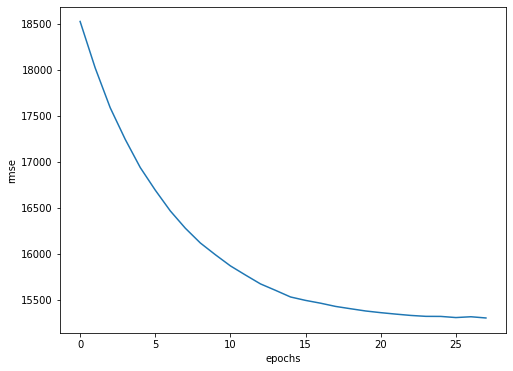

In [19]:
_,ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('epochs')
ax.set_ylabel('rmse')
ax.plot(np.arange(0,len(model['rmse-mean'])),model['rmse-mean'])

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

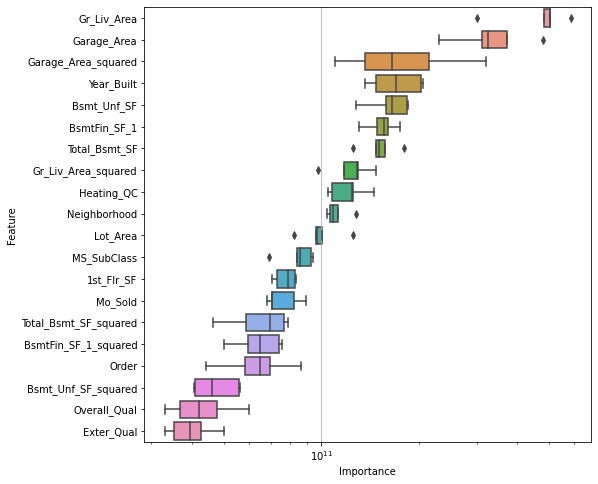

In [20]:
cvbooster = model['cvbooster']

raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_names = cvbooster.boosters[0].feature_name()
df_importance = pd.DataFrame(data=raw_importances, columns=feature_names)

# 平均値ソート
sorted_indices = df_importance.mean(axis=0).sort_values(ascending=False).index
sorted_df_importance = df_importance.loc[:, sorted_indices]

PLOT_TOP_N = 20
plot_cols = sorted_df_importance.columns[:PLOT_TOP_N]
#plot_cols = sorted_df_importance.columns
_, ax = plt.subplots(figsize=(8,8))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_df_importance[plot_cols],
           orient='h',
           ax=ax)

In [21]:
X_test = df_test.drop(['index'], axis=1)

predicted = np.zeros(X_test.shape[0])
for i in np.arange(len(cvbooster.boosters)):
    predicted += cvbooster.boosters[i].predict(X_test) / len(cvbooster.boosters)

output = pd.DataFrame({'index':df_test['index'],'predicted': predicted})
output.to_csv('./output/submit.csv', index=False, header=False)

In [22]:
import json
import datetime

meta = {
    'model':MODEL_NAME,
    'cv_score':cv_score,
    'created_at':datetime.datetime.now().strftime('%Y%m%d%H%M%S')
}

with open('./output/submit.json', 'w') as f:
    json.dump(meta, f)

In [23]:
print(cv_score)

15300.449778939059
